In [1]:
from torch.utils.data import Dataset
import os
from PIL import Image
from torchvision import transforms
from torch.nn import Module
import torch.nn as nn
import torch
from torchvision import models
import torch.optim as optim
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import joblib

In [2]:
num_class = 3
batch_size = 48
mode = 3
class CustomDataset(Dataset):
    def __init__(self, root_folder, mode, num_class):
        self.root_folder = root_folder
        self.num_class = num_class
        self.list_of_classes = self.getListOfClasses()
        self.mode = mode
        self.count_per_category = 48
        self.category_map = self.getCategoryMap()
        self.category_wise_image_paths = self.getCategoryWiseImagePaths()
        self.printSummary()
        
    def printSummary(self):
        print(f'num_class: {self.num_class}')
        print(f'list of classes: {self.list_of_classes}')
        print(f'length: {self.count_per_category * self.num_class}')

    def getCategoryWiseImagePaths(self):
        category_wise_image_paths = {}
        for folder_name in self.list_of_classes:
            image_names = []
            if self.mode == 1:
                default_folder_path = os.path.join(self.root_folder, folder_name, 'default')
                files = [os.path.join('default', f) for f in os.listdir(default_folder_path) if os.path.isfile(os.path.join(default_folder_path, f))]
                image_names.extend(files)
            if self.mode == 2:
                real_folder_path = os.path.join(self.root_folder, folder_name, 'real_world')
                files = [os.path.join('real_world', f) for f in os.listdir(real_folder_path) if os.path.isfile(os.path.join(real_folder_path, f))]
                image_names.extend(files)
            category_wise_image_paths[self.category_map[folder_name]] = image_names
        return category_wise_image_paths
        
        
    def getListOfClasses(self):
        files = [f for f in os.listdir(self.root_folder) if os.listdir(os.path.join(self.root_folder, f))]
        files = sorted(files)
        files = files[:num_class]
        return files
    
    def getCategoryMap(self):
        category_map = {}
        i = 0
        for category in self.list_of_classes:
            category_map[category] = i
            i += 1
        return category_map
    def __len__(self):
        return self.count_per_category * self.num_class
    
    def __getitem__(self, index):
        category_index = index // self.count_per_category
        image_number = index % self.count_per_category
        image_path = self.category_wise_image_paths[category_index][image_number]
        full_image_path = os.path.join(self.root_folder, self.list_of_classes[category_index], image_path)
        return  self.doTransform(full_image_path), category_index
    
    def doTransform(self, image_path):
        img = Image.open(image_path)
        transform = transforms.Compose([
            transforms.Resize((196,196)),
            transforms.ToTensor(),
            transforms.GaussianBlur(kernel_size=(7, 13), sigma=(0.1, 0.2)),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        img = transform(img)
        return img

In [3]:
folder_path = 'images/images'
mode = 1
training_data = CustomDataset(folder_path, mode, num_class)
train_dl = DataLoader(training_data, batch_size, shuffle=True)

num_class: 3
list of classes: ['paper_cups', 'plastic_trash_bags', 'plastic_water_bottles']
length: 144


In [4]:
mode = 2
test_data = CustomDataset(folder_path, mode, num_class)
test_dl = DataLoader(test_data, batch_size, shuffle=True)

num_class: 3
list of classes: ['paper_cups', 'plastic_trash_bags', 'plastic_water_bottles']
length: 144


In [5]:
image, category_index = training_data[1] 
print(training_data.list_of_classes)
print(image.shape, training_data.list_of_classes[category_index])

['paper_cups', 'plastic_trash_bags', 'plastic_water_bottles']
torch.Size([3, 196, 196]) paper_cups


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


torch.Size([3, 196, 196]) tensor(2)


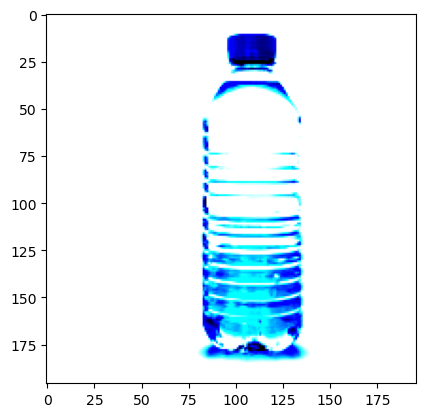

In [6]:
images, labels = next(iter(train_dl))
print(images[0].shape, labels[0])
plt.imshow(images[0].permute(1,2,0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9295317..2.64].


torch.Size([3, 196, 196]) tensor(2)


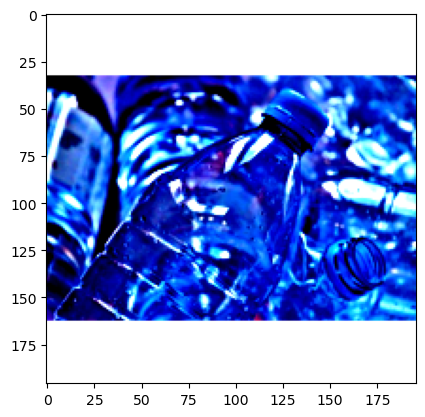

In [7]:
images, labels = next(iter(test_dl))
print(images[0].shape, labels[0])
plt.imshow(images[0].permute(1,2,0))
plt.show()

In [8]:
class CustomResNet(Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        num_ftrs = resnet.fc.in_features
        resnet.fc = nn.Linear(num_ftrs, num_class)
        self.model = resnet
    
    def forward(self, image):
        x = self.model(image)
        return x

In [9]:
model = CustomResNet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)
print(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

cuda:0


In [10]:
num_epochs = 50
dl = train_dl
dataset_size = len(dl)
entries = len(training_data)
print(f'entries: {entries}')
for epoch in range(num_epochs):
    print(f'started epoch {epoch + 1}')
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in dl:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)

        corrects = torch.sum(preds == labels.data)

        running_corrects += corrects
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / entries
    accuracy = running_corrects / entries
    print(f'Epoch Loss: {epoch_loss} and accuracy is {accuracy}')
print('Training complete')

entries: 144
started epoch 1
Epoch Loss: 0.5926235814889272 and accuracy is 0.7083333134651184
started epoch 2
Epoch Loss: 0.08706372852126758 and accuracy is 0.9722222089767456
started epoch 3
Epoch Loss: 0.06891075273354848 and accuracy is 0.9791666865348816
started epoch 4
Epoch Loss: 0.04695260307441155 and accuracy is 0.9722222089767456
started epoch 5
Epoch Loss: 0.04661837747941414 and accuracy is 0.9861111044883728
started epoch 6
Epoch Loss: 0.008643236787368854 and accuracy is 1.0
started epoch 7
Epoch Loss: 0.015648388614257176 and accuracy is 0.9930555820465088
started epoch 8
Epoch Loss: 0.005358753299030165 and accuracy is 1.0
started epoch 9
Epoch Loss: 0.005618333234451711 and accuracy is 1.0
started epoch 10
Epoch Loss: 0.009997056098654866 and accuracy is 0.9930555820465088
started epoch 11
Epoch Loss: 0.06678224680945277 and accuracy is 0.9791666865348816
started epoch 12
Epoch Loss: 0.006732320723434289 and accuracy is 1.0
started epoch 13
Epoch Loss: 0.020926218169

In [11]:
joblib.dump(model, 'model.joblib')

['model.joblib']